In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### GetData


In [3]:
df = pd.read_csv('Coffee-modified.csv')
df = df.filter(['Total.Cup.Points', 'Species','Country.of.Origin','Processing.Method', 'Aroma', 'Flavor', 'Aftertaste',
'Acidity','Body', 'Balance', 'Uniformity', 'Moisture', 'altitude_mean_meters'])

In [4]:
df.dropna(inplace=True)
df.describe()

,Total.Cup.Points,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Moisture,altitude_mean_meters
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,82.126949,7.567488,7.513779,7.385633,7.526221,7.504287,7.499302,9.870219,0.094985,1816.792017
std,2.631610,0.301361,0.324487,0.332735,0.307827,0.272824,0.340801,0.445371,0.043468,9112.472930
min,59.830000,5.080000,6.170000,6.170000,5.250000,6.330000,6.080000,6.000000,0.000000,1.000000
25%,81.170000,7.420000,7.330000,7.170000,7.330000,7.330000,7.330000,10.000000,0.100000,1100.000000
50%,82.420000,7.580000,7.500000,7.420000,7.500000,7.500000,7.500000,10.000000,0.110000,1310.640000
75%,83.580000,7.750000,7.670000,7.580000,7.670000,7.670000,7.670000,10.000000,0.120000,1600.000000
max,90.580000,8.750000,8.830000,8.670000,8.750000,8.500000,8.580000,10.000000,0.170000,190164.000000


In [5]:
Y = pd.DataFrame()
Y = df.iloc[:, 0:1]
X = df.drop(df.columns[0],axis = 1)
Y = Y.reset_index(drop = True)
X = X.reset_index(drop = True)


### Data Preparation


In [6]:
# Process Y from values to Coffee Bean Grade
# define Bean_Grade = [1,2,3] using
rating_pctile = np.percentile( Y, [75, 90])
Bean_grade = []
NSamples = [0,0,0]
for i in Y.values:
    if i < rating_pctile [0]: #75 percentile
        NSamples[0] += 1
        Bean_grade.append(1)
    if rating_pctile [0] <= i < rating_pctile [1]: # 90 percentile
        NSamples[1] += 1
        Bean_grade.append(2)
    if i >= rating_pctile[1]:
        NSamples[2] += 1
        Bean_grade.append(3) 

In [7]:
fig = px.bar( Y, x = [1,2,3], y = NSamples, color=NSamples, range_y=[0.0,1000])
fig.show()


In [8]:
Y["Bean_grade"] = Bean_grade
Y.drop(["Total.Cup.Points"],axis =1,inplace= True)

In [9]:
X1 = X.select_dtypes("object")
X2 = X.select_dtypes("number")
X2

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Moisture,altitude_mean_meters
0,8.67,8.83,8.67,8.75,8.50,8.42,10.00,0.12,2075.00
1,8.75,8.67,8.50,8.58,8.42,8.42,10.00,0.12,2075.00
2,8.17,8.58,8.42,8.42,8.50,8.25,10.00,0.11,2000.00
3,8.25,8.50,8.25,8.50,8.42,8.33,10.00,0.12,2075.00
4,8.08,8.58,8.50,8.50,7.67,8.42,10.00,0.10,1822.50
...,...,...,...,...,...,...,...,...,...
998,7.00,6.33,6.17,6.50,6.67,6.17,8.00,0.10,1450.00
999,7.08,6.83,6.25,7.42,7.25,6.75,10.00,0.11,900.00
1000,6.75,6.58,6.42,6.67,7.08,6.67,9.33,0.14,350.00
1001,7.25,6.58,6.33,6.25,6.42,6.08,6.00,0.13,1100.00


In [10]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_scale = pd.DataFrame(standard_scaler.fit_transform(X2.values),index = X2.index,columns=X2.columns)

In [11]:
dataCorr = X_scale.corr()
lower = pd.DataFrame(np.tril(dataCorr, -1),columns = dataCorr.columns)
to_drop = [column for column in lower if any(lower[column] > 0.8)]
to_drop

['Flavor']

In [12]:
X_scale.drop(to_drop, inplace=True, axis=1)
X_scale

,Aroma,Aftertaste,Acidity,Body,Balance,Uniformity,Moisture,altitude_mean_meters
0,3.660274,3.861950,3.977528,3.651469,2.702919,0.291544,0.575762,0.028350
1,3.925869,3.350779,3.424993,3.358094,2.702919,0.291544,0.575762,0.028350
2,2.000305,3.110228,2.904961,3.651469,2.203845,0.291544,0.345595,0.020115
3,2.265900,2.599057,3.164977,3.358094,2.438704,0.291544,0.575762,0.028350
4,1.701510,3.350779,3.164977,0.607701,2.702919,0.291544,0.115428,0.000627
...,...,...,...,...,...,...,...,...
998,-1.884024,-3.655275,-3.335427,-3.059490,-3.902470,-4.201335,0.115428,-0.040272
999,-1.618429,-3.414724,-0.345241,-0.932520,-2.199748,0.291544,0.345595,-0.100659
1000,-2.714009,-2.903553,-2.782892,-1.555942,-2.434606,-1.213570,1.036097,-0.161046
1001,-1.054039,-3.174173,-4.147977,-3.976288,-4.166686,-8.694214,0.805930,-0.078700


In [13]:
standard_scaler = preprocessing.StandardScaler()
X_ohe = pd.get_dummies(X1,columns=X1.columns, drop_first=True )
X_ohe

,Country.of.Origin_Burundi,Country.of.Origin_China,Country.of.Origin_Colombia,Country.of.Origin_Costa Rica,Country.of.Origin_Cote d?Ivoire,Country.of.Origin_Ecuador,Country.of.Origin_El Salvador,Country.of.Origin_Ethiopia,Country.of.Origin_Guatemala,Country.of.Origin_Haiti,...,Country.of.Origin_Thailand,Country.of.Origin_Uganda,Country.of.Origin_United States,Country.of.Origin_United States (Puerto Rico),Country.of.Origin_Vietnam,Country.of.Origin_Zambia,Processing.Method_Other,Processing.Method_Pulped natural / honey,Processing.Method_Semi-washed / Semi-pulped,Processing.Method_Washed / Wet
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [14]:
X = X_ohe.join(X_scale)
X

,Country.of.Origin_Burundi,Country.of.Origin_China,Country.of.Origin_Colombia,Country.of.Origin_Costa Rica,Country.of.Origin_Cote d?Ivoire,Country.of.Origin_Ecuador,Country.of.Origin_El Salvador,Country.of.Origin_Ethiopia,Country.of.Origin_Guatemala,Country.of.Origin_Haiti,...,Processing.Method_Semi-washed / Semi-pulped,Processing.Method_Washed / Wet,Aroma,Aftertaste,Acidity,Body,Balance,Uniformity,Moisture,altitude_mean_meters
0,0,0,0,0,0,0,0,1,0,0,...,0,1,3.660274,3.861950,3.977528,3.651469,2.702919,0.291544,0.575762,0.028350
1,0,0,0,0,0,0,0,1,0,0,...,0,1,3.925869,3.350779,3.424993,3.358094,2.702919,0.291544,0.575762,0.028350
2,0,0,0,0,0,0,0,1,0,0,...,0,0,2.000305,3.110228,2.904961,3.651469,2.203845,0.291544,0.345595,0.020115
3,0,0,0,0,0,0,0,1,0,0,...,0,1,2.265900,2.599057,3.164977,3.358094,2.438704,0.291544,0.575762,0.028350
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1.701510,3.350779,3.164977,0.607701,2.702919,0.291544,0.115428,0.000627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0,0,0,0,0,0,0,0,0,0,...,0,1,-1.884024,-3.655275,-3.335427,-3.059490,-3.902470,-4.201335,0.115428,-0.040272
999,0,0,0,0,0,0,0,0,0,0,...,0,1,-1.618429,-3.414724,-0.345241,-0.932520,-2.199748,0.291544,0.345595,-0.100659
1000,0,0,0,0,0,0,0,0,0,1,...,0,0,-2.714009,-2.903553,-2.782892,-1.555942,-2.434606,-1.213570,1.036097,-0.161046
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,-1.054039,-3.174173,-4.147977,-3.976288,-4.166686,-8.694214,0.805930,-0.078700


In [15]:
seed = 6
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
X_train
Y

,Bean_grade
0,3
1,3
2,3
3,3
4,3
...,...
998,1
999,1
1000,1
1001,1


In [16]:
Y_train

,Bean_grade
368,1
533,1
241,2
344,1
742,1
...,...
618,1
980,1
227,2
713,1


### KNN Model

In [17]:
k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 25, 35] # try at least 3 values
modelKNN1 = KNeighborsClassifier(n_neighbors=1, p=2)
modelKNN2 = KNeighborsClassifier(n_neighbors=3, p=2)
modelKNN3 = KNeighborsClassifier(n_neighbors=5, p=2)
modelKNN1.fit(X_train,Y_train)
modelKNN2.fit(X_train,Y_train)
modelKNN3.fit(X_train,Y_train)


c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KNeighborsClassifier()

In [18]:
y_pred1 = modelKNN1.predict(X_test)
KNNScore1 = accuracy_score(Y_test, y_pred1)
y_pred2 = modelKNN2.predict(X_test)
KNNScore2 = accuracy_score(Y_test, y_pred2)
y_pred3 = modelKNN3.predict(X_test)
KNNScore3 = accuracy_score(Y_test, y_pred3)

In [19]:
KNN_score_list = []
KNN_score_list.append(KNNScore1)
KNN_score_list.append(KNNScore2)
KNN_score_list.append(KNNScore3)
fig = px.bar(KNN_score_list,x=[1,3,5],y=KNN_score_list,color = KNN_score_list,range_y=[0.7,1.0])
fig.show()

In [20]:
# Print Confusion Matrix and Classification Report for best k
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, y_pred3))
print('Classification Report: ')
print(classification_report(Y_test, y_pred3))

Confusion Matrix: 
[[215   4   1]
 [ 16  31   4]
 [  0   6  24]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.93      0.98      0.95       220
           2       0.76      0.61      0.67        51
           3       0.83      0.80      0.81        30

    accuracy                           0.90       301
   macro avg       0.84      0.80      0.81       301
weighted avg       0.89      0.90      0.89       301



### Decision Tree Model Training and Testing

In [21]:
ASM_function = ['entropy', 'gini']
maxD = [4, 5, 6, None] # try at least 2 values

In [22]:
ModelDT1 = DecisionTreeClassifier(criterion='entropy', splitter='best',max_depth = 4 )
ModelDT2 = DecisionTreeClassifier(criterion='entropy', splitter='best',max_depth = 5 )
ModelDT3 = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth = 4 )
ModelDT4 = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth = 5 )
ModelDT1.fit(X_train,Y_train)
ModelDT2.fit(X_train,Y_train)
ModelDT3.fit(X_train,Y_train)
ModelDT4.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=5)

In [23]:
y_pred1 = ModelDT1.predict(X_test)
DTScore1 = accuracy_score(Y_test, y_pred1)
print(DTScore1)

0.840531561461794


In [24]:
y_pred2 = ModelDT2.predict(X_test)
DTScore2 = accuracy_score(Y_test, y_pred2)
print(DTScore2)

0.8704318936877077


In [25]:
y_pred3 = ModelDT3.predict(X_test)
DTScore3 = accuracy_score(Y_test, y_pred3)
print(DTScore3)

0.8106312292358804


In [26]:
y_pred4 = ModelDT4.predict(X_test)
DTScore4 = accuracy_score(Y_test, y_pred4)
print(DTScore4)

0.8338870431893688


In [27]:
# Print Confusion Matrix and Classification Report for best k
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, y_pred2))
print('Classification Report: ')
print(classification_report(Y_test, y_pred2))

Confusion Matrix: 
[[204  11   5]
 [ 15  30   6]
 [  0   2  28]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       220
           2       0.70      0.59      0.64        51
           3       0.72      0.93      0.81        30

    accuracy                           0.87       301
   macro avg       0.78      0.82      0.79       301
weighted avg       0.87      0.87      0.87       301



In [28]:
# #Print Confusion Matrix and Classification Report for best k
# print('Confusion Matrix: ')
# print(confusion_matrix(Y_test,y_pred1))
# print('Classifiction Report: ')
# print(classification_report(Y_test,y_pred1))

[Text(0.37790697674418605, 0.9166666666666666, 'Balance <= 0.369\nentropy = 1.059\nsamples = 702\nvalue = [526, 101, 75]\nclass = 1'),
 Text(0.12209302325581395, 0.75, 'Aftertaste <= 0.464\nentropy = 0.206\nsamples = 465\nvalue = [450, 15, 0]\nclass = 1'),
 Text(0.046511627906976744, 0.5833333333333334, 'Body <= 1.983\nentropy = 0.025\nsamples = 413\nvalue = [412, 1, 0]\nclass = 1'),
 Text(0.023255813953488372, 0.4166666666666667, 'entropy = 0.0\nsamples = 412\nvalue = [412, 0, 0]\nclass = 1'),
 Text(0.06976744186046512, 0.4166666666666667, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = 2'),
 Text(0.19767441860465115, 0.5833333333333334, 'Acidity <= 0.321\nentropy = 0.84\nsamples = 52\nvalue = [38, 14, 0]\nclass = 1'),
 Text(0.11627906976744186, 0.4166666666666667, 'Aroma <= 0.739\nentropy = 0.449\nsamples = 32\nvalue = [29, 3, 0]\nclass = 1'),
 Text(0.06976744186046512, 0.25, 'Moisture <= 0.231\nentropy = 0.229\nsamples = 27\nvalue = [26, 1, 0]\nclass = 1'),
 Text(0.046511627

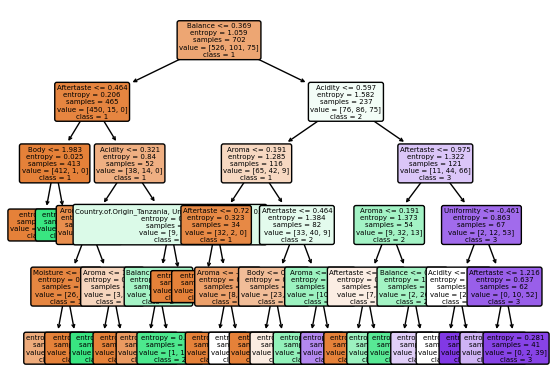

In [29]:
from sklearn import tree
# modelDt = []
# modelDt.append(ModelDT1)
# modelDt.append(ModelDT2)
# modelDt.append(ModelDT3)
# modelDt.append(ModelDT4)
# modelDt
feature_names = X_train.columns
Labels = np.unique(Y_train)
label = []
for i in Labels:
    label.append(str(i))
tree.plot_tree( ModelDT2,feature_names = feature_names,class_names = label,rounded = True,filled = True, fontsize=5)

# plt.show()

### Random Forest Model Training and Testing

In [30]:
ASM_function = ['entropy','gini']
nEstimator = 100 
nJob = 2
rState = 10

In [31]:
RandomF = RandomForestClassifier(criterion = 'entropy',n_estimators=nEstimator,n_jobs=nJob,random_state=rState)
RandomF1 = RandomForestClassifier(criterion = 'gini',n_estimators=nEstimator,n_jobs=nJob,random_state=rState)
RandomF.fit(X_train,Y_train)
RandomF1.fit(X_train,Y_train)


C:\Users\Nuchtu\AppData\Local\Temp\ipykernel_1480\1841864414.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Nuchtu\AppData\Local\Temp\ipykernel_1480\1841864414.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(n_jobs=2, random_state=10)

In [32]:
#Model Testing
y_pred = RandomF.predict(X_test)
RFScore = accuracy_score(Y_test,y_pred)
RFScore

0.893687707641196

In [33]:
y_pred1 = RandomF1.predict(X_test)
RFScore1 = accuracy_score(Y_test,y_pred1)
RFScore1

0.893687707641196

In [34]:
#print confusion matrix and classification report for best k
print('Confusion Matrix: ')
print(confusion_matrix(Y_test,y_pred))
print('Classification Report: ')
print(classification_report(Y_test,y_pred))

Confusion Matrix: 
[[213   6   1]
 [ 17  31   3]
 [  0   5  25]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       220
           2       0.74      0.61      0.67        51
           3       0.86      0.83      0.85        30

    accuracy                           0.89       301
   macro avg       0.84      0.80      0.82       301
weighted avg       0.89      0.89      0.89       301



<AxesSubplot:>

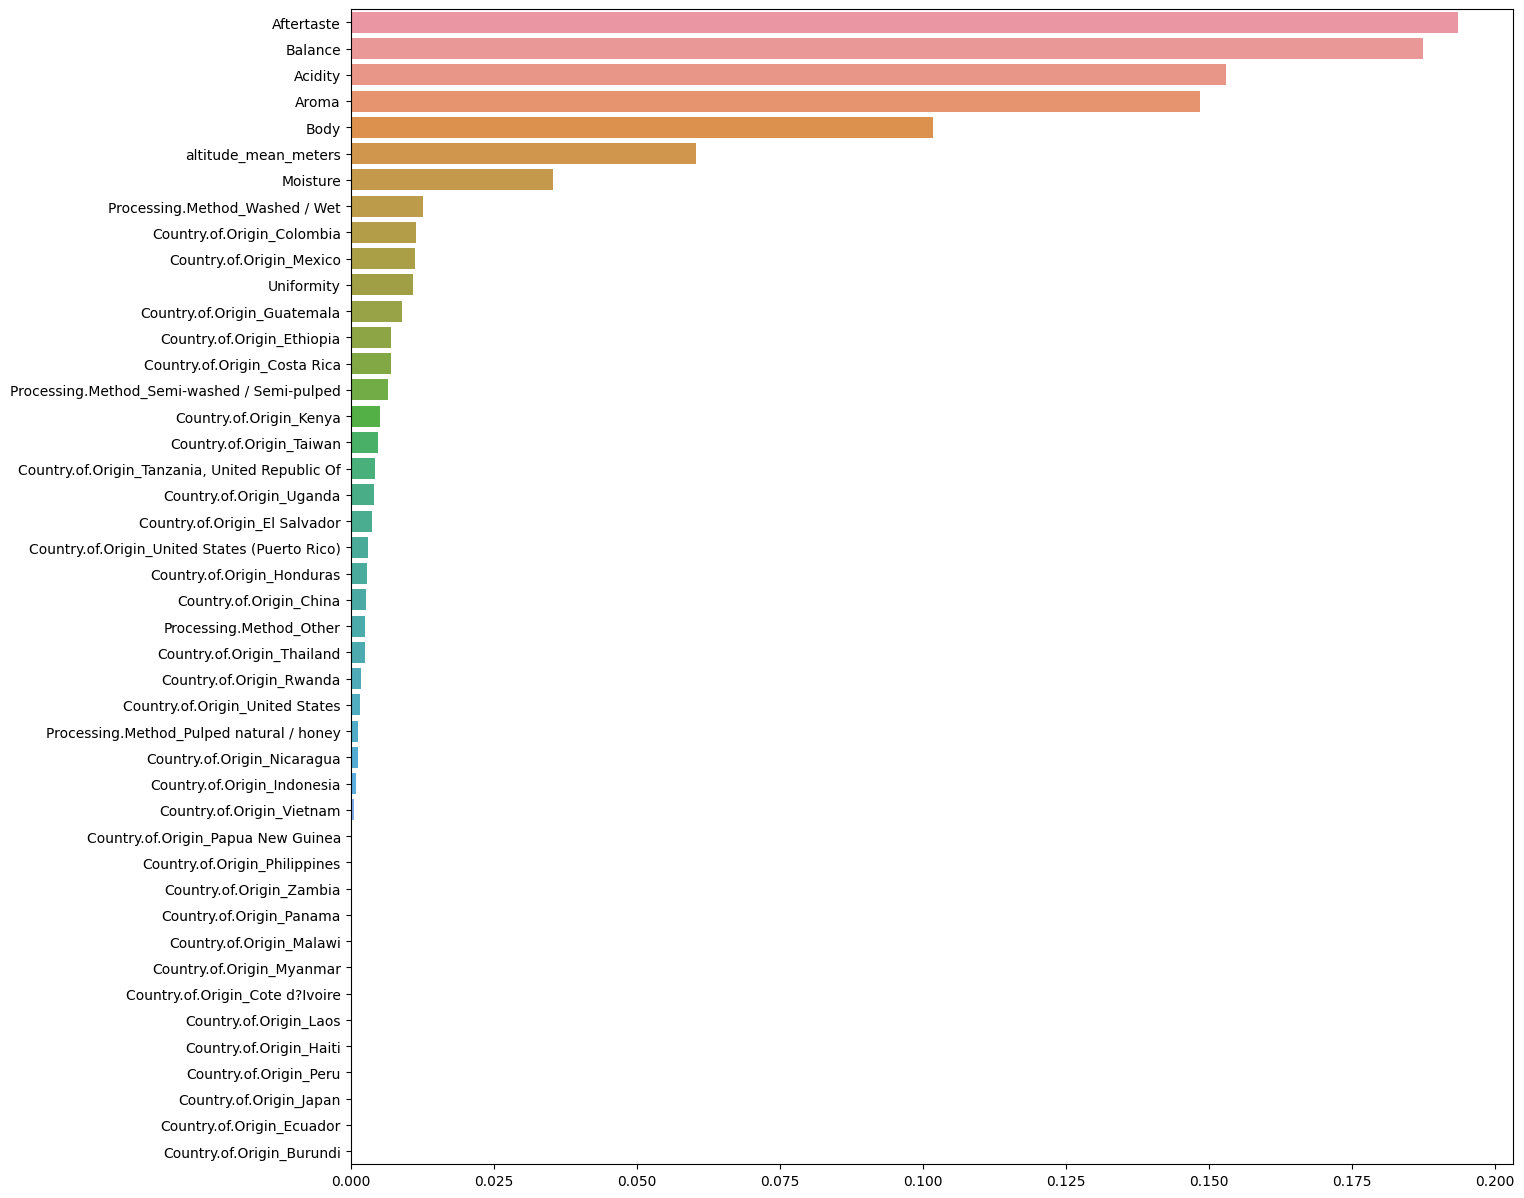

In [35]:
feature_imp = pd.Series(RandomF.feature_importances_,index = feature_names).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(x=feature_imp,y=feature_imp.index)

Text(0.5, 1.0, 'Estimator:4')

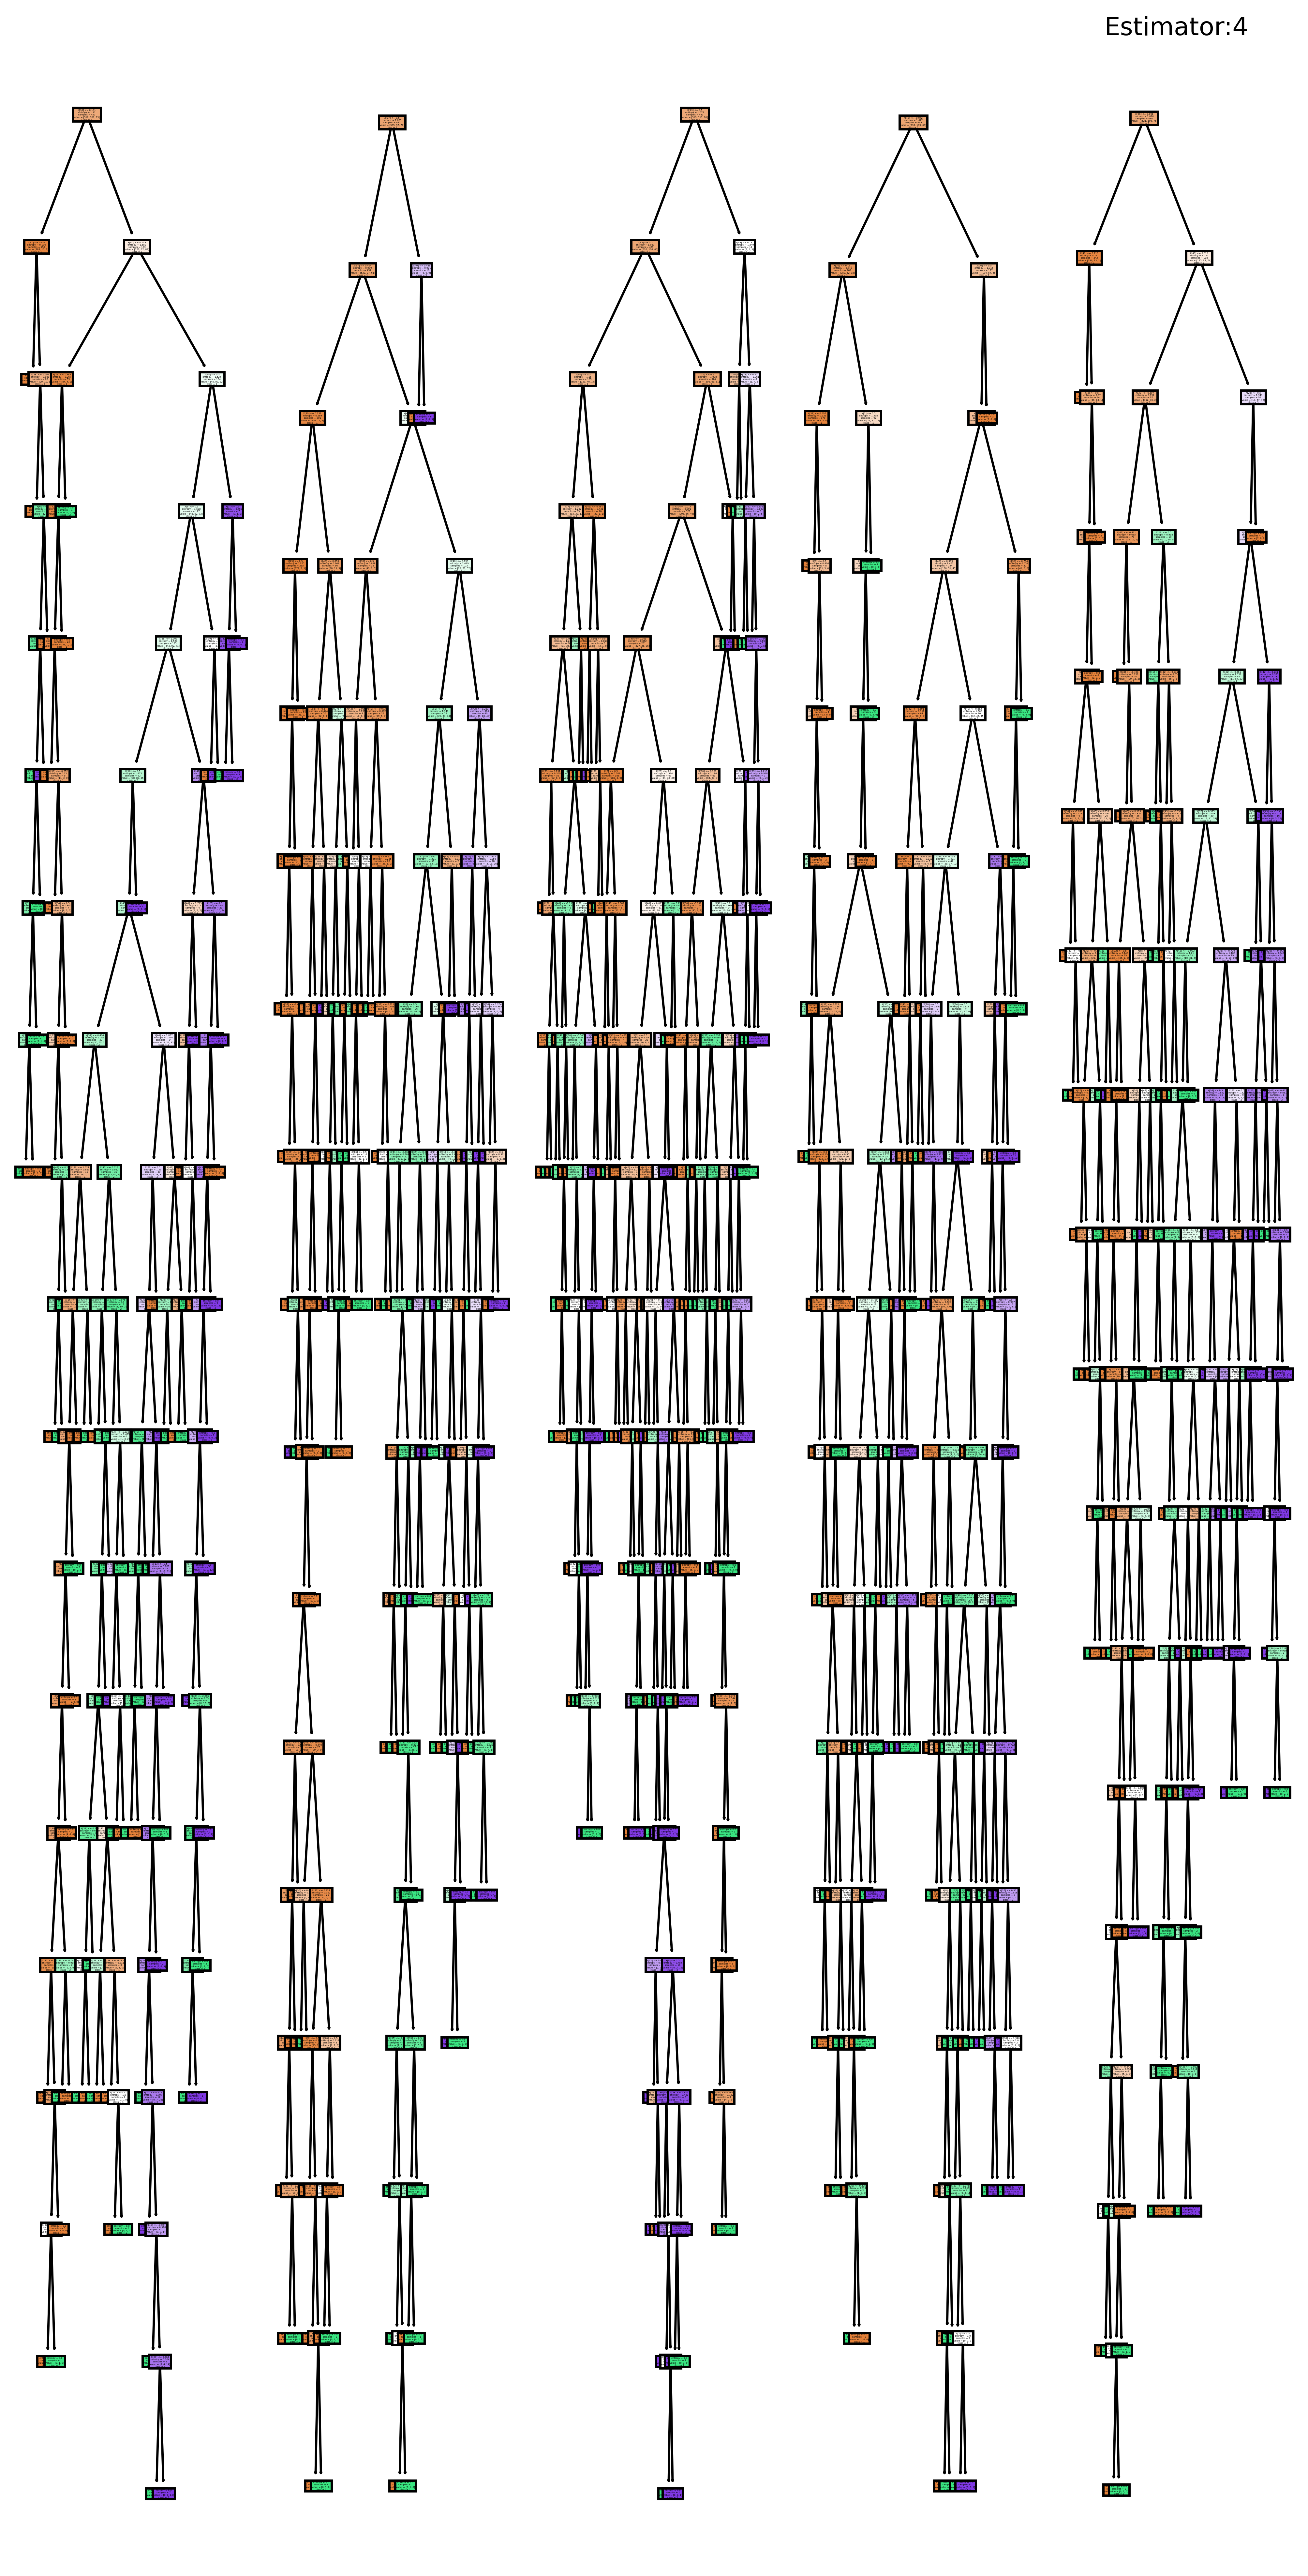

In [36]:
fig,axes = plt.subplots(nrows=1 , ncols = 5 , figsize= (10,20),dpi = 500)
for index in range(0,5):
    tree.plot_tree(RandomF.estimators_[index],class_names=label,filled = True,ax = axes[index])
axes[index].set_title('Estimator:'+str(index),fontsize=11)

### Hyperparameter Tuning (GridsearchCV)

In [37]:
#Create Model List
classification = {'KNN':KNeighborsClassifier(),'DT':DecisionTreeClassifier(),'RF':RandomForestClassifier()}

In [38]:
#Create Parameter Dicitonary for KNN
K_list = [1,3,5,7,9,11,13,15,17,19,21,23,35,45]
KNN_param = dict(n_neighbors = K_list)
KNN_param

{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 35, 45]}

In [39]:
#Create Parameter Dictionary for Decision Tree
ASM_function = ['entropy','gini']
maxD = [4,5,6,None]
maxF =['auto','log2',None]
minSample = [1,2,4]
DT_param = dict(criterion = ASM_function,max_depth = maxD,min_samples_leaf = minSample,max_features = maxF)


In [40]:
#Create Parameter Dictionary for Random Forest
nEst = [10,30,50,100]
RF_param = dict(n_estimators = nEst,criterion = ASM_function,max_depth = maxD,min_samples_leaf= minSample,max_features = maxF)

In [41]:
for EST in classification:
    model = classification[EST]
    if EST == 'KNN':
        param = KNN_param
    elif EST == 'DT':
        param = DT_param
    else:
        param = RF_param
    grid = GridSearchCV(estimator = model,
                        n_jobs=8,
                        verbose=10,
                        scoring='accuracy',
                        cv=5,
                        param_grid=param)
    grid_result = grid.fit(X_train,Y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [42]:
# Show Best Parameters 
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best score:  0.8889260385005067


In [48]:
means   = grid_result.cv_results_['mean_test_score']
stds    = grid_result.cv_results_['std_test_score']
params  = grid_result.cv_results_['params']
data_entropy = []
data_gini = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    if param['criterion'] == 'entropy':
        data_entropy.append({'means': mean, 'stds': stdev})
    elif param['criterion'] == 'gini':
        data_gini.append({'means': mean, 'stds': stdev})

0.851773 (0.024871) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 10}
0.846140 (0.016700) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 30}
0.846150 (0.011567) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}
0.850385 (0.014663) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
0.837609 (0.016471) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 10}
0.851854 (0.009365) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 30}
0.846150 (0.013258) with: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 50}
0.860375 (0.007687) with: {'criterion': 'entropy', 'max_depth

144

<AxesSubplot:>

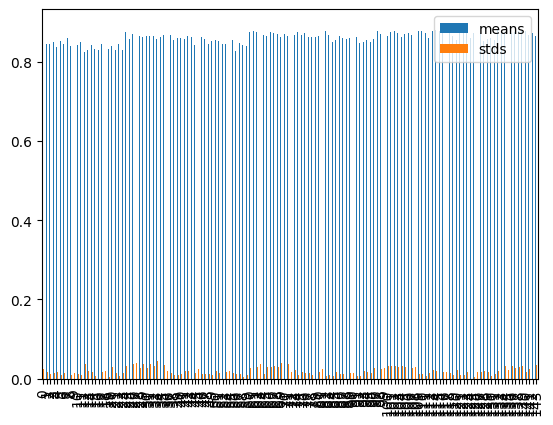

In [45]:
df_entropy = pd.DataFrame(data=data_entropy)
df_entropy.plot.bar()

<AxesSubplot:>

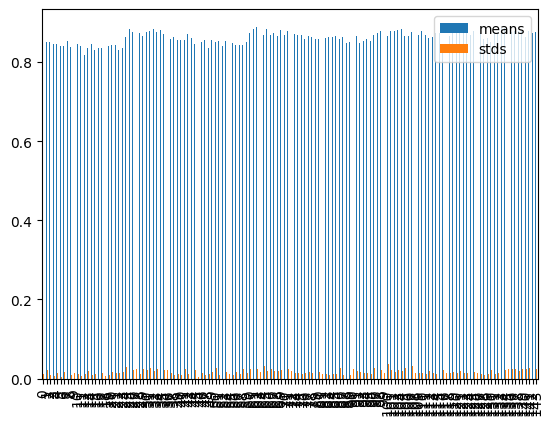

In [46]:
df_gini = pd.DataFrame(data=data_gini)
df_gini.plot.bar()